### Setting
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import pickle
from IPython.display import HTML, display
from torchvision.datasets import ImageFolder
import torch.optim as optim
from statistics import mean
import copy

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [8]:
class ProgressMonitor(object):

    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)

    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))

    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

In [5]:
# # 압축 풀기
# import zipfile

# fantasy_zip = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/인이활/project B/images(시도1).zip')
# fantasy_zip.extractall('/content/drive/MyDrive/Colab Notebooks/인이활/project B/images(시도1)')
# fantasy_zip.close()

### 시도 1
---


In [9]:
from torchvision.datasets import ImageFolder

data_dir = "/content/drive/MyDrive/Colab Notebooks/인이활/project B/images(시도1)"

size = 64

transform = T.Compose([
    T.Resize((size, size)),
    T.RandomHorizontalFlip(),
    T.RandomCrop(size, padding=8),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder(root=data_dir, transform=transform)

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

모델

In [10]:
class CNN_CPCPCCPFF(nn.Module):

    def __init__(self, channel1=32, channel2=64, channel3=128, fc1=256, fc2=128):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d( in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel2, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel3, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),

            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.fc_layers = nn.Sequential(

            nn.Linear( 8*8*channel3, fc1 ),
            nn.BatchNorm1d(fc1),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc1, fc2),
            nn.BatchNorm1d(fc2),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc2, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view( x.size(0), -1 )
        x = self.fc_layers(x)
        return x

In [11]:
class CNN_CCPCCPCCPFF(nn.Module):

    def __init__(self, channel1=32, channel2=64, channel3=128, fc1=256, fc2=128):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d( in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel1, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel2, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d( in_channels=channel2, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.Conv2d( in_channels=channel3, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.fc_layers = nn.Sequential(

            nn.Linear( 8*8*channel3, fc1 ),
            nn.BatchNorm1d(fc1),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc1, fc2),
            nn.BatchNorm1d(fc2),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(fc2, 10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view( x.size(0), -1 )
        x = self.fc_layers(x)
        return x

In [13]:
batch_size = 32
learning_rate = 0.001
num_epochs = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

테스트 모델


In [14]:
model = CNN_CPCPCCPFF()

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)

In [15]:
def train(optimizer, model, num_epochs=10, first_epoch=1, scheduler=lr_scheduler):

    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    best_model = copy.deepcopy(model)
    best_acc = 0.0

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)
        model.train()
        progress = ProgressMonitor(length=len(train_set))
        correct_train = 0
        batch_losses = []

        for batch, targets in train_loader:
            batch = batch.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)
            progress.update(batch.shape[0], mean(batch_losses) )

        train_losses.append( mean(batch_losses))

        if scheduler:
            scheduler.step()

        model.eval()
        y_pred = []
        correct_test = 0

        with torch.no_grad():
            for batch, targets in test_loader:
                batch = batch.to(device)
                targets = targets.to(device)
                outputs = model(batch)
                loss = criterion(outputs, targets)
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)

        train_acc = correct_train.item() / len(train_set)
        test_acc = correct_test.item() / len(test_set)

        acc = test_acc

        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model)

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))
    model = copy.deepcopy(best_model)
    print('Best test accuracy: {:4f}'.format(best_acc))
    return train_losses, test_losses, y_pred

In [16]:
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

Epoch 1


Loss: 2.2564 3166 / 3166,3166


Training accuracy: 18.19%
Test accuracy: 26.01%

Epoch 2


Loss: 2.0408 3166 / 3166,3166


Training accuracy: 27.38%
Test accuracy: 30.18%

Epoch 3


Loss: 1.9645 3166 / 3166,3166


Training accuracy: 31.40%
Test accuracy: 26.64%

Epoch 4


Loss: 1.8903 3166 / 3166,3166


Training accuracy: 34.08%
Test accuracy: 33.46%

Epoch 5


Loss: 1.8204 3166 / 3166,3166


Training accuracy: 36.61%
Test accuracy: 35.48%

Epoch 6


Loss: 1.7830 3166 / 3166,3166


Training accuracy: 38.63%
Test accuracy: 37.50%

Epoch 7


Loss: 1.7411 3166 / 3166,3166


Training accuracy: 39.77%
Test accuracy: 41.67%

Epoch 8


Loss: 1.7087 3166 / 3166,3166


Training accuracy: 40.78%
Test accuracy: 39.39%

Epoch 9


Loss: 1.6898 3166 / 3166,3166


Training accuracy: 41.82%
Test accuracy: 42.30%

Epoch 10


Loss: 1.6212 3166 / 3166,3166


Training accuracy: 45.17%
Test accuracy: 40.15%

Epoch 11


Loss: 1.5619 3166 / 3166,3166


Training accuracy: 46.37%
Test accuracy: 44.57%

Epoch 12


Loss: 1.5384 3166 / 3166,3166


Training accuracy: 48.01%
Test accuracy: 46.34%

Epoch 13


Loss: 1.5189 3166 / 3166,3166


Training accuracy: 49.05%
Test accuracy: 48.11%

Epoch 14


Loss: 1.4864 3166 / 3166,3166


Training accuracy: 50.19%
Test accuracy: 49.87%

Epoch 15


Loss: 1.4777 3166 / 3166,3166


Training accuracy: 50.22%
Test accuracy: 48.36%

Epoch 16


Loss: 1.4510 3166 / 3166,3166


Training accuracy: 50.41%
Test accuracy: 48.99%

Epoch 17


Loss: 1.4509 3166 / 3166,3166


Training accuracy: 51.83%
Test accuracy: 47.47%

Epoch 18


Loss: 1.4270 3166 / 3166,3166


Training accuracy: 51.52%
Test accuracy: 48.36%

Epoch 19


Loss: 1.4202 3166 / 3166,3166


Training accuracy: 52.72%
Test accuracy: 48.61%

Epoch 20


Loss: 1.4112 3166 / 3166,3166


Training accuracy: 53.00%
Test accuracy: 50.13%

Epoch 21


Loss: 1.3537 3166 / 3166,3166


Training accuracy: 55.87%
Test accuracy: 48.36%

Epoch 22


Loss: 1.3562 3166 / 3166,3166


Training accuracy: 55.12%
Test accuracy: 53.41%

Epoch 23


Loss: 1.3229 3166 / 3166,3166


Training accuracy: 56.57%
Test accuracy: 51.64%

Epoch 24


Loss: 1.3272 3166 / 3166,3166


Training accuracy: 56.54%
Test accuracy: 51.77%

Epoch 25


Loss: 1.3029 3166 / 3166,3166


Training accuracy: 57.52%
Test accuracy: 50.51%

Epoch 26


Loss: 1.3203 3166 / 3166,3166


Training accuracy: 55.50%
Test accuracy: 53.66%

Epoch 27


Loss: 1.2920 3166 / 3166,3166


Training accuracy: 57.71%
Test accuracy: 52.53%

Epoch 28


Loss: 1.2715 3166 / 3166,3166


Training accuracy: 59.41%
Test accuracy: 53.91%

Epoch 29


Loss: 1.2863 3166 / 3166,3166


Training accuracy: 58.40%
Test accuracy: 50.76%

Epoch 30


Loss: 1.2754 3166 / 3166,3166


Training accuracy: 57.61%
Test accuracy: 53.66%

Epoch 31


Loss: 1.2588 3166 / 3166,3166


Training accuracy: 58.88%
Test accuracy: 52.15%

Epoch 32


Loss: 1.2487 3166 / 3166,3166


Training accuracy: 59.76%
Test accuracy: 53.79%

Epoch 33


Loss: 1.2440 3166 / 3166,3166


Training accuracy: 59.35%
Test accuracy: 53.41%

Epoch 34


Loss: 1.2361 3166 / 3166,3166


Training accuracy: 60.27%
Test accuracy: 53.28%

Epoch 35


Loss: 1.2422 3166 / 3166,3166


Training accuracy: 60.01%
Test accuracy: 51.39%

Epoch 36


Loss: 1.2307 3166 / 3166,3166


Training accuracy: 60.58%
Test accuracy: 50.25%

Epoch 37


Loss: 1.2262 3166 / 3166,3166


Training accuracy: 60.20%
Test accuracy: 50.88%

Epoch 38


Loss: 1.2331 3166 / 3166,3166


Training accuracy: 59.76%
Test accuracy: 52.78%

Epoch 39


Loss: 1.2196 3166 / 3166,3166


Training accuracy: 61.72%
Test accuracy: 52.02%

Epoch 40


Loss: 1.2246 3166 / 3166,3166


Training accuracy: 60.45%
Test accuracy: 52.65%

Epoch 41


Loss: 1.2084 3166 / 3166,3166


Training accuracy: 61.59%
Test accuracy: 52.40%

Epoch 42


Loss: 1.1959 3166 / 3166,3166


Training accuracy: 62.73%
Test accuracy: 54.29%

Epoch 43


Loss: 1.2158 3166 / 3166,3166


Training accuracy: 61.72%
Test accuracy: 52.15%

Epoch 44


Loss: 1.1971 3166 / 3166,3166


Training accuracy: 62.19%
Test accuracy: 53.03%

Epoch 45


Loss: 1.2068 3166 / 3166,3166


Training accuracy: 61.62%
Test accuracy: 52.53%

Epoch 46


Loss: 1.2042 3166 / 3166,3166


Training accuracy: 60.45%
Test accuracy: 51.64%

Epoch 47


Loss: 1.2082 3166 / 3166,3166


Training accuracy: 61.31%
Test accuracy: 53.79%

Epoch 48


Loss: 1.2016 3166 / 3166,3166


Training accuracy: 61.31%
Test accuracy: 52.90%

Epoch 49


Loss: 1.2010 3166 / 3166,3166


Training accuracy: 61.21%
Test accuracy: 50.63%

Epoch 50


Loss: 1.2012 3166 / 3166,3166


Training accuracy: 61.24%
Test accuracy: 53.28%

Epoch 51


Loss: 1.2075 3166 / 3166,3166


Training accuracy: 61.53%
Test accuracy: 53.54%

Epoch 52


Loss: 1.1994 3166 / 3166,3166


Training accuracy: 61.50%
Test accuracy: 52.02%

Epoch 53


Loss: 1.1990 3166 / 3166,3166


Training accuracy: 62.13%
Test accuracy: 53.28%

Epoch 54


Loss: 1.2014 3166 / 3166,3166


Training accuracy: 62.29%
Test accuracy: 54.29%

Epoch 55


Loss: 1.2136 3166 / 3166,3166


Training accuracy: 61.37%
Test accuracy: 55.05%

Epoch 56


Loss: 1.1962 3166 / 3166,3166


Training accuracy: 61.40%
Test accuracy: 52.90%

Epoch 57


Loss: 1.2017 3166 / 3166,3166


Training accuracy: 61.34%
Test accuracy: 51.39%

Epoch 58


Loss: 1.2001 3166 / 3166,3166


Training accuracy: 61.47%
Test accuracy: 52.78%

Epoch 59


Loss: 1.2128 3166 / 3166,3166


Training accuracy: 60.87%
Test accuracy: 51.52%

Epoch 60


Loss: 1.1878 3166 / 3166,3166


Training accuracy: 62.10%
Test accuracy: 53.54%

Epoch 61


Loss: 1.2047 3166 / 3166,3166


Training accuracy: 61.37%
Test accuracy: 52.27%

Epoch 62


Loss: 1.1965 3166 / 3166,3166


Training accuracy: 61.50%
Test accuracy: 53.79%

Epoch 63


Loss: 1.1842 3166 / 3166,3166


Training accuracy: 62.89%
Test accuracy: 52.90%

Epoch 64


Loss: 1.2104 3166 / 3166,3166


Training accuracy: 60.08%
Test accuracy: 52.27%

Epoch 65


Loss: 1.1931 3166 / 3166,3166


Training accuracy: 61.72%
Test accuracy: 54.29%

Epoch 66


Loss: 1.1855 3166 / 3166,3166


Training accuracy: 61.78%
Test accuracy: 52.78%

Epoch 67


Loss: 1.1968 3166 / 3166,3166


Training accuracy: 62.13%
Test accuracy: 51.52%

Epoch 68


Loss: 1.1969 3166 / 3166,3166


Training accuracy: 61.75%
Test accuracy: 54.92%

Epoch 69


Loss: 1.1878 3166 / 3166,3166


Training accuracy: 62.79%
Test accuracy: 52.78%

Epoch 70


Loss: 1.2099 3166 / 3166,3166


Training accuracy: 60.17%
Test accuracy: 54.42%

Epoch 71


Loss: 1.2243 3166 / 3166,3166


Training accuracy: 59.95%
Test accuracy: 53.91%

Epoch 72


Loss: 1.1712 3166 / 3166,3166


Training accuracy: 62.73%
Test accuracy: 53.03%

Epoch 73


Loss: 1.1885 3166 / 3166,3166


Training accuracy: 61.88%
Test accuracy: 54.29%

Epoch 74


Loss: 1.1944 3166 / 3166,3166


Training accuracy: 61.37%
Test accuracy: 53.28%

Epoch 75


Loss: 1.1857 3166 / 3166,3166


Training accuracy: 62.92%
Test accuracy: 53.03%

Epoch 76


Loss: 1.2105 3166 / 3166,3166


Training accuracy: 60.55%
Test accuracy: 53.03%

Epoch 77


Loss: 1.1691 3166 / 3166,3166


Training accuracy: 62.44%
Test accuracy: 53.66%

Epoch 78


Loss: 1.1897 3166 / 3166,3166


Training accuracy: 62.32%
Test accuracy: 52.53%

Epoch 79


Loss: 1.2078 3166 / 3166,3166


Training accuracy: 60.58%
Test accuracy: 53.79%

Epoch 80


Loss: 1.1993 3166 / 3166,3166


Training accuracy: 61.75%
Test accuracy: 54.92%

Epoch 81


Loss: 1.1901 3166 / 3166,3166


Training accuracy: 62.35%
Test accuracy: 53.41%

Epoch 82


Loss: 1.1978 3166 / 3166,3166


Training accuracy: 61.02%
Test accuracy: 52.40%

Epoch 83


Loss: 1.2000 3166 / 3166,3166


Training accuracy: 61.24%
Test accuracy: 54.04%

Epoch 84


Loss: 1.2118 3166 / 3166,3166


Training accuracy: 60.42%
Test accuracy: 52.90%

Epoch 85


Loss: 1.1953 3166 / 3166,3166


Training accuracy: 61.88%
Test accuracy: 52.02%

Epoch 86


Loss: 1.2042 3166 / 3166,3166


Training accuracy: 60.99%
Test accuracy: 51.89%

Epoch 87


Loss: 1.1816 3166 / 3166,3166


Training accuracy: 61.62%
Test accuracy: 53.16%

Epoch 88


Loss: 1.2042 3166 / 3166,3166


Training accuracy: 60.96%
Test accuracy: 53.28%

Epoch 89


Loss: 1.2140 3166 / 3166,3166


Training accuracy: 60.83%
Test accuracy: 53.41%

Epoch 90


Loss: 1.1944 3166 / 3166,3166


Training accuracy: 60.96%
Test accuracy: 53.16%

Epoch 91


Loss: 1.1952 3166 / 3166,3166


Training accuracy: 61.15%
Test accuracy: 53.54%

Epoch 92


Loss: 1.2013 3166 / 3166,3166


Training accuracy: 61.43%
Test accuracy: 53.16%

Epoch 93


Loss: 1.1935 3166 / 3166,3166


Training accuracy: 62.35%
Test accuracy: 52.27%

Epoch 94


Loss: 1.2054 3166 / 3166,3166


Training accuracy: 61.09%
Test accuracy: 51.52%

Epoch 95


Loss: 1.1948 3166 / 3166,3166


Training accuracy: 61.56%
Test accuracy: 50.88%

Epoch 96


Loss: 1.2101 3166 / 3166,3166


Training accuracy: 61.28%
Test accuracy: 51.64%

Epoch 97


Loss: 1.1697 3166 / 3166,3166


Training accuracy: 62.67%
Test accuracy: 50.63%

Epoch 98


Loss: 1.2065 3166 / 3166,3166


Training accuracy: 60.58%
Test accuracy: 50.38%

Epoch 99


Loss: 1.2032 3166 / 3166,3166


Training accuracy: 61.37%
Test accuracy: 51.52%

Epoch 100


Loss: 1.2134 3166 / 3166,3166


Training accuracy: 61.02%
Test accuracy: 53.03%

Best test accuracy: 0.550505


모델별 비교

In [17]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [18]:
def train_and_calculate_best_acc(optimizer, model, num_epochs=50, first_epoch=1, scheduler=lr_scheduler):

    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    best_model = copy.deepcopy(model)
    best_acc = 0.0

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)
        model.train()
        progress = ProgressMonitor(length=len(train_set))
        correct_train = 0
        batch_losses = []

        for batch, targets in train_loader:
            batch = batch.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)
            progress.update(batch.shape[0], mean(batch_losses) )

        train_losses.append( mean(batch_losses))

        if scheduler:
            scheduler.step()

        model.eval()
        y_pred = []
        correct_test = 0

        with torch.no_grad():
            for batch, targets in test_loader:
                batch = batch.to(device)
                targets = targets.to(device)
                outputs = model(batch)
                loss = criterion(outputs, targets)
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)

        train_acc = correct_train.item() / len(train_set)
        test_acc = correct_test.item() / len(test_set)

        acc = test_acc

        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model)

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))
    model = copy.deepcopy(best_model)
    print('Best test accuracy: {:4f}'.format(best_acc))
    return best_acc

In [19]:
# 너무 오래 걸려서 절반씩 실행

learning_rate = 0.001
channel_set = [[32, 64, 128]]
fc_set = [[256, 128], [512, 256]]
acc_model1 = []
acc_model2 = []
for chnls in channel_set:
    for fcs in fc_set:
        print(chnls, fcs)

        model1 = CNN_CPCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model1.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model1.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model1)
        acc_model1.append(acc)

        model2 = CNN_CCPCCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model2.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model2.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model2)
        acc_model2.append(acc)

acc_model1, acc_model2

[32, 64, 128] [256, 128]
Epoch 1


Loss: 2.2760 3166 / 3166,3166


Training accuracy: 17.34%
Test accuracy: 25.00%

Epoch 2


Loss: 2.0741 3166 / 3166,3166


Training accuracy: 25.36%
Test accuracy: 31.06%

Epoch 3


Loss: 1.9808 3166 / 3166,3166


Training accuracy: 29.50%
Test accuracy: 31.82%

Epoch 4


Loss: 1.9019 3166 / 3166,3166


Training accuracy: 33.16%
Test accuracy: 37.12%

Epoch 5


Loss: 1.8468 3166 / 3166,3166


Training accuracy: 35.79%
Test accuracy: 31.19%

Epoch 6


Loss: 1.8178 3166 / 3166,3166


Training accuracy: 36.86%
Test accuracy: 39.14%

Epoch 7


Loss: 1.7593 3166 / 3166,3166


Training accuracy: 38.88%
Test accuracy: 36.62%

Epoch 8


Loss: 1.7437 3166 / 3166,3166


Training accuracy: 40.11%
Test accuracy: 30.56%

Epoch 9


Loss: 1.6855 3166 / 3166,3166


Training accuracy: 42.10%
Test accuracy: 44.32%

Epoch 10


Loss: 1.6686 3166 / 3166,3166


Training accuracy: 43.62%
Test accuracy: 43.56%

Epoch 11


Loss: 1.6219 3166 / 3166,3166


Training accuracy: 44.79%
Test accuracy: 44.32%

Epoch 12


Loss: 1.5776 3166 / 3166,3166


Training accuracy: 45.93%
Test accuracy: 44.32%

Epoch 13


Loss: 1.5772 3166 / 3166,3166


Training accuracy: 46.56%
Test accuracy: 47.47%

Epoch 14


Loss: 1.5350 3166 / 3166,3166


Training accuracy: 47.76%
Test accuracy: 46.09%

Epoch 15


Loss: 1.5336 3166 / 3166,3166


Training accuracy: 47.73%
Test accuracy: 38.64%

Epoch 16


Loss: 1.5027 3166 / 3166,3166


Training accuracy: 48.17%
Test accuracy: 47.98%

Epoch 17


Loss: 1.4962 3166 / 3166,3166


Training accuracy: 49.37%
Test accuracy: 48.48%

Epoch 18


Loss: 1.4549 3166 / 3166,3166


Training accuracy: 50.22%
Test accuracy: 47.73%

Epoch 19


Loss: 1.4249 3166 / 3166,3166


Training accuracy: 51.74%
Test accuracy: 46.34%

Epoch 20


Loss: 1.4076 3166 / 3166,3166


Training accuracy: 52.59%
Test accuracy: 50.00%

Epoch 21


Loss: 1.4053 3166 / 3166,3166


Training accuracy: 51.67%
Test accuracy: 47.35%

Epoch 22


Loss: 1.3772 3166 / 3166,3166


Training accuracy: 53.19%
Test accuracy: 44.07%

Epoch 23


Loss: 1.3571 3166 / 3166,3166


Training accuracy: 52.94%
Test accuracy: 49.37%

Epoch 24


Loss: 1.3639 3166 / 3166,3166


Training accuracy: 54.11%
Test accuracy: 50.38%

Epoch 25


Loss: 1.3233 3166 / 3166,3166


Training accuracy: 55.27%
Test accuracy: 50.88%

Epoch 26


Loss: 1.3165 3166 / 3166,3166


Training accuracy: 55.31%
Test accuracy: 51.39%

Epoch 27


Loss: 1.2964 3166 / 3166,3166


Training accuracy: 56.57%
Test accuracy: 51.39%

Epoch 28


Loss: 1.2691 3166 / 3166,3166


Training accuracy: 56.60%
Test accuracy: 50.88%

Epoch 29


Loss: 1.2505 3166 / 3166,3166


Training accuracy: 58.12%
Test accuracy: 52.78%

Epoch 30


Loss: 1.2497 3166 / 3166,3166


Training accuracy: 57.30%
Test accuracy: 54.04%

Epoch 31


Loss: 1.2351 3166 / 3166,3166


Training accuracy: 57.49%
Test accuracy: 51.26%

Epoch 32


Loss: 1.2196 3166 / 3166,3166


Training accuracy: 59.51%
Test accuracy: 49.75%

Epoch 33


Loss: 1.1781 3166 / 3166,3166


Training accuracy: 60.11%
Test accuracy: 51.14%

Epoch 34


Loss: 1.1702 3166 / 3166,3166


Training accuracy: 59.63%
Test accuracy: 52.90%

Epoch 35


Loss: 1.1621 3166 / 3166,3166


Training accuracy: 60.01%
Test accuracy: 53.03%

Epoch 36


Loss: 1.1650 3166 / 3166,3166


Training accuracy: 59.98%
Test accuracy: 53.41%

Epoch 37


Loss: 1.1472 3166 / 3166,3166


Training accuracy: 61.05%
Test accuracy: 54.80%

Epoch 38


Loss: 1.1311 3166 / 3166,3166


Training accuracy: 60.20%
Test accuracy: 54.80%

Epoch 39


Loss: 1.1057 3166 / 3166,3166


Training accuracy: 62.92%
Test accuracy: 54.29%

Epoch 40


Loss: 1.1247 3166 / 3166,3166


Training accuracy: 61.21%
Test accuracy: 51.64%

Epoch 41


Loss: 1.0889 3166 / 3166,3166


Training accuracy: 63.77%
Test accuracy: 53.79%

Epoch 42


Loss: 1.0694 3166 / 3166,3166


Training accuracy: 63.96%
Test accuracy: 54.04%

Epoch 43


Loss: 1.0524 3166 / 3166,3166


Training accuracy: 63.90%
Test accuracy: 52.90%

Epoch 44


Loss: 1.0628 3166 / 3166,3166


Training accuracy: 63.39%
Test accuracy: 55.56%

Epoch 45


Loss: 1.0215 3166 / 3166,3166


Training accuracy: 64.47%
Test accuracy: 56.44%

Epoch 46


Loss: 1.0129 3166 / 3166,3166


Training accuracy: 66.08%
Test accuracy: 53.28%

Epoch 47


Loss: 1.0060 3166 / 3166,3166


Training accuracy: 65.89%
Test accuracy: 55.05%

Epoch 48


Loss: 0.9974 3166 / 3166,3166


Training accuracy: 65.03%
Test accuracy: 56.94%

Epoch 49


Loss: 0.9577 3166 / 3166,3166


Training accuracy: 68.07%
Test accuracy: 58.71%

Epoch 50


Loss: 0.9699 3166 / 3166,3166


Training accuracy: 66.46%
Test accuracy: 57.20%

Best test accuracy: 0.587121
Epoch 1


Loss: 2.2533 3166 / 3166,3166


Training accuracy: 18.76%
Test accuracy: 24.75%

Epoch 2


Loss: 2.0599 3166 / 3166,3166


Training accuracy: 26.63%
Test accuracy: 26.89%

Epoch 3


Loss: 1.9779 3166 / 3166,3166


Training accuracy: 30.51%
Test accuracy: 32.07%

Epoch 4


Loss: 1.9033 3166 / 3166,3166


Training accuracy: 32.50%
Test accuracy: 31.94%

Epoch 5


Loss: 1.8399 3166 / 3166,3166


Training accuracy: 35.82%
Test accuracy: 34.22%

Epoch 6


Loss: 1.7939 3166 / 3166,3166


Training accuracy: 38.53%
Test accuracy: 37.50%

Epoch 7


Loss: 1.7484 3166 / 3166,3166


Training accuracy: 39.36%
Test accuracy: 41.04%

Epoch 8


Loss: 1.7034 3166 / 3166,3166


Training accuracy: 41.95%
Test accuracy: 42.17%

Epoch 9


Loss: 1.6715 3166 / 3166,3166


Training accuracy: 43.21%
Test accuracy: 41.16%

Epoch 10


Loss: 1.6223 3166 / 3166,3166


Training accuracy: 44.31%
Test accuracy: 43.69%

Epoch 11


Loss: 1.6071 3166 / 3166,3166


Training accuracy: 45.42%
Test accuracy: 43.06%

Epoch 12


Loss: 1.5548 3166 / 3166,3166


Training accuracy: 47.57%
Test accuracy: 46.21%

Epoch 13


Loss: 1.5287 3166 / 3166,3166


Training accuracy: 47.19%
Test accuracy: 45.96%

Epoch 14


Loss: 1.5008 3166 / 3166,3166


Training accuracy: 48.64%
Test accuracy: 44.07%

Epoch 15


Loss: 1.4749 3166 / 3166,3166


Training accuracy: 49.15%
Test accuracy: 46.34%

Epoch 16


Loss: 1.4528 3166 / 3166,3166


Training accuracy: 50.19%
Test accuracy: 47.60%

Epoch 17


Loss: 1.4253 3166 / 3166,3166


Training accuracy: 51.83%
Test accuracy: 50.00%

Epoch 18


Loss: 1.3992 3166 / 3166,3166


Training accuracy: 52.46%
Test accuracy: 44.07%

Epoch 19


Loss: 1.3858 3166 / 3166,3166


Training accuracy: 53.54%
Test accuracy: 49.75%

Epoch 20


Loss: 1.3709 3166 / 3166,3166


Training accuracy: 52.91%
Test accuracy: 50.63%

Epoch 21


Loss: 1.3458 3166 / 3166,3166


Training accuracy: 53.92%
Test accuracy: 47.60%

Epoch 22


Loss: 1.3297 3166 / 3166,3166


Training accuracy: 54.39%
Test accuracy: 52.90%

Epoch 23


Loss: 1.2914 3166 / 3166,3166


Training accuracy: 55.72%
Test accuracy: 50.38%

Epoch 24


Loss: 1.2551 3166 / 3166,3166


Training accuracy: 57.58%
Test accuracy: 52.78%

Epoch 25


Loss: 1.2773 3166 / 3166,3166


Training accuracy: 56.38%
Test accuracy: 53.03%

Epoch 26


Loss: 1.2610 3166 / 3166,3166


Training accuracy: 57.08%
Test accuracy: 52.02%

Epoch 27


Loss: 1.2008 3166 / 3166,3166


Training accuracy: 59.03%
Test accuracy: 52.65%

Epoch 28


Loss: 1.2177 3166 / 3166,3166


Training accuracy: 58.40%
Test accuracy: 52.53%

Epoch 29


Loss: 1.1878 3166 / 3166,3166


Training accuracy: 59.70%
Test accuracy: 54.92%

Epoch 30


Loss: 1.1657 3166 / 3166,3166


Training accuracy: 61.02%
Test accuracy: 53.03%

Epoch 31


Loss: 1.1494 3166 / 3166,3166


Training accuracy: 62.03%
Test accuracy: 51.52%

Epoch 32


Loss: 1.1440 3166 / 3166,3166


Training accuracy: 61.31%
Test accuracy: 54.29%

Epoch 33


Loss: 1.1157 3166 / 3166,3166


Training accuracy: 61.59%
Test accuracy: 55.30%

Epoch 34


Loss: 1.1182 3166 / 3166,3166


Training accuracy: 61.78%
Test accuracy: 56.44%

Epoch 35


Loss: 1.0941 3166 / 3166,3166


Training accuracy: 62.92%
Test accuracy: 54.29%

Epoch 36


Loss: 1.0598 3166 / 3166,3166


Training accuracy: 64.50%
Test accuracy: 54.67%

Epoch 37


Loss: 1.0594 3166 / 3166,3166


Training accuracy: 63.46%
Test accuracy: 57.45%

Epoch 38


Loss: 1.0333 3166 / 3166,3166


Training accuracy: 64.56%
Test accuracy: 55.43%

Epoch 39


Loss: 1.0071 3166 / 3166,3166


Training accuracy: 66.08%
Test accuracy: 58.59%

Epoch 40


Loss: 1.0293 3166 / 3166,3166


Training accuracy: 65.03%
Test accuracy: 58.71%

Epoch 41


Loss: 0.9986 3166 / 3166,3166


Training accuracy: 66.08%
Test accuracy: 56.94%

Epoch 42


Loss: 0.9859 3166 / 3166,3166


Training accuracy: 67.06%
Test accuracy: 57.45%

Epoch 43


Loss: 0.9742 3166 / 3166,3166


Training accuracy: 67.06%
Test accuracy: 58.21%

Epoch 44


Loss: 0.9571 3166 / 3166,3166


Training accuracy: 67.18%
Test accuracy: 57.95%

Epoch 45


Loss: 0.9620 3166 / 3166,3166


Training accuracy: 67.44%
Test accuracy: 57.70%

Epoch 46


Loss: 0.9128 3166 / 3166,3166


Training accuracy: 69.52%
Test accuracy: 58.46%

Epoch 47


Loss: 0.9082 3166 / 3166,3166


Training accuracy: 68.79%
Test accuracy: 55.93%

Epoch 48


Loss: 0.9097 3166 / 3166,3166


Training accuracy: 69.65%
Test accuracy: 58.84%

Epoch 49


Loss: 0.9266 3166 / 3166,3166


Training accuracy: 68.86%
Test accuracy: 58.84%

Epoch 50


Loss: 0.8657 3166 / 3166,3166


Training accuracy: 69.74%
Test accuracy: 60.73%

Best test accuracy: 0.607323
[32, 64, 128] [512, 256]
Epoch 1


Loss: 2.2142 3166 / 3166,3166


Training accuracy: 20.37%
Test accuracy: 22.60%

Epoch 2


Loss: 2.0012 3166 / 3166,3166


Training accuracy: 28.87%
Test accuracy: 27.78%

Epoch 3


Loss: 1.9098 3166 / 3166,3166


Training accuracy: 31.71%
Test accuracy: 31.06%

Epoch 4


Loss: 1.8511 3166 / 3166,3166


Training accuracy: 35.12%
Test accuracy: 29.92%

Epoch 5


Loss: 1.7803 3166 / 3166,3166


Training accuracy: 38.41%
Test accuracy: 35.86%

Epoch 6


Loss: 1.7530 3166 / 3166,3166


Training accuracy: 39.80%
Test accuracy: 39.90%

Epoch 7


Loss: 1.6955 3166 / 3166,3166


Training accuracy: 40.43%
Test accuracy: 41.16%

Epoch 8


Loss: 1.6699 3166 / 3166,3166


Training accuracy: 41.98%
Test accuracy: 35.23%

Epoch 9


Loss: 1.6317 3166 / 3166,3166


Training accuracy: 44.63%
Test accuracy: 39.27%

Epoch 10


Loss: 1.5967 3166 / 3166,3166


Training accuracy: 45.17%
Test accuracy: 44.07%

Epoch 11


Loss: 1.5516 3166 / 3166,3166


Training accuracy: 47.28%
Test accuracy: 46.09%

Epoch 12


Loss: 1.5569 3166 / 3166,3166


Training accuracy: 46.53%
Test accuracy: 45.71%

Epoch 13


Loss: 1.4852 3166 / 3166,3166


Training accuracy: 49.43%
Test accuracy: 43.56%

Epoch 14


Loss: 1.4927 3166 / 3166,3166


Training accuracy: 48.74%
Test accuracy: 48.74%

Epoch 15


Loss: 1.4419 3166 / 3166,3166


Training accuracy: 50.88%
Test accuracy: 48.61%

Epoch 16


Loss: 1.4442 3166 / 3166,3166


Training accuracy: 51.14%
Test accuracy: 46.46%

Epoch 17


Loss: 1.4139 3166 / 3166,3166


Training accuracy: 52.34%
Test accuracy: 48.36%

Epoch 18


Loss: 1.3624 3166 / 3166,3166


Training accuracy: 54.58%
Test accuracy: 46.34%

Epoch 19


Loss: 1.3660 3166 / 3166,3166


Training accuracy: 53.85%
Test accuracy: 51.77%

Epoch 20


Loss: 1.3454 3166 / 3166,3166


Training accuracy: 54.99%
Test accuracy: 49.37%

Epoch 21


Loss: 1.3216 3166 / 3166,3166


Training accuracy: 55.53%
Test accuracy: 49.49%

Epoch 22


Loss: 1.3116 3166 / 3166,3166


Training accuracy: 54.96%
Test accuracy: 47.60%

Epoch 23


Loss: 1.2999 3166 / 3166,3166


Training accuracy: 56.51%
Test accuracy: 51.52%

Epoch 24


Loss: 1.2603 3166 / 3166,3166


Training accuracy: 56.98%
Test accuracy: 50.88%

Epoch 25


Loss: 1.2420 3166 / 3166,3166


Training accuracy: 57.26%
Test accuracy: 52.02%

Epoch 26


Loss: 1.2342 3166 / 3166,3166


Training accuracy: 58.15%
Test accuracy: 51.14%

Epoch 27


Loss: 1.1889 3166 / 3166,3166


Training accuracy: 60.30%
Test accuracy: 51.77%

Epoch 28


Loss: 1.1969 3166 / 3166,3166


Training accuracy: 59.25%
Test accuracy: 50.63%

Epoch 29


Loss: 1.1784 3166 / 3166,3166


Training accuracy: 59.79%
Test accuracy: 51.89%

Epoch 30


Loss: 1.1526 3166 / 3166,3166


Training accuracy: 61.84%
Test accuracy: 53.16%

Epoch 31


Loss: 1.1264 3166 / 3166,3166


Training accuracy: 62.19%
Test accuracy: 54.55%

Epoch 32


Loss: 1.1099 3166 / 3166,3166


Training accuracy: 62.73%
Test accuracy: 54.29%

Epoch 33


Loss: 1.1208 3166 / 3166,3166


Training accuracy: 62.60%
Test accuracy: 53.41%

Epoch 34


Loss: 1.0936 3166 / 3166,3166


Training accuracy: 63.11%
Test accuracy: 51.52%

Epoch 35


Loss: 1.0639 3166 / 3166,3166


Training accuracy: 65.54%
Test accuracy: 53.66%

Epoch 36


Loss: 1.0559 3166 / 3166,3166


Training accuracy: 64.97%
Test accuracy: 54.17%

Epoch 37


Loss: 1.0124 3166 / 3166,3166


Training accuracy: 66.52%
Test accuracy: 55.93%

Epoch 38


Loss: 1.0192 3166 / 3166,3166


Training accuracy: 65.48%
Test accuracy: 51.26%

Epoch 39


Loss: 1.0162 3166 / 3166,3166


Training accuracy: 66.42%
Test accuracy: 53.41%

Epoch 40


Loss: 1.0026 3166 / 3166,3166


Training accuracy: 65.67%
Test accuracy: 54.04%

Epoch 41


Loss: 0.9801 3166 / 3166,3166


Training accuracy: 67.47%
Test accuracy: 55.18%

Epoch 42


Loss: 0.9689 3166 / 3166,3166


Training accuracy: 66.20%
Test accuracy: 56.94%

Epoch 43


Loss: 0.9520 3166 / 3166,3166


Training accuracy: 68.16%
Test accuracy: 58.46%

Epoch 44


Loss: 0.9603 3166 / 3166,3166


Training accuracy: 67.62%
Test accuracy: 54.92%

Epoch 45


Loss: 0.9091 3166 / 3166,3166


Training accuracy: 69.24%
Test accuracy: 54.42%

Epoch 46


Loss: 0.9265 3166 / 3166,3166


Training accuracy: 68.32%
Test accuracy: 55.81%

Epoch 47


Loss: 0.8945 3166 / 3166,3166


Training accuracy: 69.24%
Test accuracy: 55.56%

Epoch 48


Loss: 0.8861 3166 / 3166,3166


Training accuracy: 70.21%
Test accuracy: 55.68%

Epoch 49


Loss: 0.8554 3166 / 3166,3166


Training accuracy: 71.42%
Test accuracy: 55.81%

Epoch 50


Loss: 0.8585 3166 / 3166,3166


Training accuracy: 70.59%
Test accuracy: 56.82%

Best test accuracy: 0.584596
Epoch 1


Loss: 2.2089 3166 / 3166,3166


Training accuracy: 20.09%
Test accuracy: 21.84%

Epoch 2


Loss: 2.0197 3166 / 3166,3166


Training accuracy: 27.86%
Test accuracy: 25.51%

Epoch 3


Loss: 1.9301 3166 / 3166,3166


Training accuracy: 32.19%
Test accuracy: 34.97%

Epoch 4


Loss: 1.8476 3166 / 3166,3166


Training accuracy: 35.60%
Test accuracy: 38.01%

Epoch 5


Loss: 1.7940 3166 / 3166,3166


Training accuracy: 38.25%
Test accuracy: 32.45%

Epoch 6


Loss: 1.7363 3166 / 3166,3166


Training accuracy: 40.21%
Test accuracy: 37.88%

Epoch 7


Loss: 1.6913 3166 / 3166,3166


Training accuracy: 42.55%
Test accuracy: 45.08%

Epoch 8


Loss: 1.6453 3166 / 3166,3166


Training accuracy: 43.65%
Test accuracy: 42.05%

Epoch 9


Loss: 1.6169 3166 / 3166,3166


Training accuracy: 44.16%
Test accuracy: 41.54%

Epoch 10


Loss: 1.5663 3166 / 3166,3166


Training accuracy: 46.18%
Test accuracy: 42.55%

Epoch 11


Loss: 1.5336 3166 / 3166,3166


Training accuracy: 48.77%
Test accuracy: 45.08%

Epoch 12


Loss: 1.5147 3166 / 3166,3166


Training accuracy: 49.12%
Test accuracy: 47.10%

Epoch 13


Loss: 1.4896 3166 / 3166,3166


Training accuracy: 48.74%
Test accuracy: 47.98%

Epoch 14


Loss: 1.4274 3166 / 3166,3166


Training accuracy: 53.03%
Test accuracy: 49.49%

Epoch 15


Loss: 1.4027 3166 / 3166,3166


Training accuracy: 52.34%
Test accuracy: 49.24%

Epoch 16


Loss: 1.3853 3166 / 3166,3166


Training accuracy: 52.40%
Test accuracy: 48.99%

Epoch 17


Loss: 1.3739 3166 / 3166,3166


Training accuracy: 53.19%
Test accuracy: 46.84%

Epoch 18


Loss: 1.3323 3166 / 3166,3166


Training accuracy: 54.64%
Test accuracy: 50.88%

Epoch 19


Loss: 1.3047 3166 / 3166,3166


Training accuracy: 56.03%
Test accuracy: 51.64%

Epoch 20


Loss: 1.3055 3166 / 3166,3166


Training accuracy: 55.59%
Test accuracy: 52.27%

Epoch 21


Loss: 1.2663 3166 / 3166,3166


Training accuracy: 57.77%
Test accuracy: 50.63%

Epoch 22


Loss: 1.2071 3166 / 3166,3166


Training accuracy: 59.98%
Test accuracy: 52.53%

Epoch 23


Loss: 1.2365 3166 / 3166,3166


Training accuracy: 57.45%
Test accuracy: 52.53%

Epoch 24


Loss: 1.1913 3166 / 3166,3166


Training accuracy: 60.11%
Test accuracy: 53.03%

Epoch 25


Loss: 1.1739 3166 / 3166,3166


Training accuracy: 59.60%
Test accuracy: 54.42%

Epoch 26


Loss: 1.1782 3166 / 3166,3166


Training accuracy: 61.15%
Test accuracy: 54.17%

Epoch 27


Loss: 1.1328 3166 / 3166,3166


Training accuracy: 61.72%
Test accuracy: 53.79%

Epoch 28


Loss: 1.1214 3166 / 3166,3166


Training accuracy: 62.38%
Test accuracy: 53.41%

Epoch 29


Loss: 1.1040 3166 / 3166,3166


Training accuracy: 63.68%
Test accuracy: 56.82%

Epoch 30


Loss: 1.0824 3166 / 3166,3166


Training accuracy: 62.86%
Test accuracy: 55.05%

Epoch 31


Loss: 1.0661 3166 / 3166,3166


Training accuracy: 64.09%
Test accuracy: 54.42%

Epoch 32


Loss: 1.0588 3166 / 3166,3166


Training accuracy: 64.53%
Test accuracy: 55.43%

Epoch 33


Loss: 1.0290 3166 / 3166,3166


Training accuracy: 64.91%
Test accuracy: 56.82%

Epoch 34


Loss: 1.0164 3166 / 3166,3166


Training accuracy: 65.57%
Test accuracy: 55.81%

Epoch 35


Loss: 1.0098 3166 / 3166,3166


Training accuracy: 66.17%
Test accuracy: 56.82%

Epoch 36


Loss: 0.9959 3166 / 3166,3166


Training accuracy: 66.52%
Test accuracy: 59.34%

Epoch 37


Loss: 0.9673 3166 / 3166,3166


Training accuracy: 66.80%
Test accuracy: 58.46%

Epoch 38


Loss: 0.9627 3166 / 3166,3166


Training accuracy: 68.19%
Test accuracy: 57.70%

Epoch 39


Loss: 0.9190 3166 / 3166,3166


Training accuracy: 69.46%
Test accuracy: 56.06%

Epoch 40


Loss: 0.9207 3166 / 3166,3166


Training accuracy: 68.41%
Test accuracy: 58.46%

Epoch 41


Loss: 0.9117 3166 / 3166,3166


Training accuracy: 68.89%
Test accuracy: 57.20%

Epoch 42


Loss: 0.8847 3166 / 3166,3166


Training accuracy: 70.72%
Test accuracy: 58.33%

Epoch 43


Loss: 0.8894 3166 / 3166,3166


Training accuracy: 70.53%
Test accuracy: 57.20%

Epoch 44


Loss: 0.8429 3166 / 3166,3166


Training accuracy: 72.02%
Test accuracy: 58.33%

Epoch 45


Loss: 0.8440 3166 / 3166,3166


Training accuracy: 70.75%
Test accuracy: 57.83%

Epoch 46


Loss: 0.8208 3166 / 3166,3166


Training accuracy: 72.71%
Test accuracy: 58.84%

Epoch 47


Loss: 0.8307 3166 / 3166,3166


Training accuracy: 70.97%
Test accuracy: 56.19%

Epoch 48


Loss: 0.7743 3166 / 3166,3166


Training accuracy: 73.69%
Test accuracy: 55.81%

Epoch 49


Loss: 0.8092 3166 / 3166,3166


Training accuracy: 72.11%
Test accuracy: 56.57%

Epoch 50


Loss: 0.8109 3166 / 3166,3166


Training accuracy: 72.36%
Test accuracy: 60.35%

Best test accuracy: 0.603535


([0.5871212121212122, 0.5845959595959596],
 [0.6073232323232324, 0.6035353535353535])

In [20]:
# 너무 오래 걸려서 절반씩 실행

learning_rate = 0.001
channel_set = [[64, 128, 256]]
fc_set = [[256, 128], [512, 256]]
for chnls in channel_set:
    for fcs in fc_set:
        print(chnls, fcs)

        model1 = CNN_CPCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model1.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model1.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model1)
        acc_model1.append(acc)

        model2 = CNN_CCPCCPCCPFF(channel1=chnls[0], channel2=chnls[1], channel3=chnls[2], fc1=fcs[0], fc2=fcs[1])
        model2.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.NAdam(model2.parameters(), lr=learning_rate)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.33)
        acc = train_and_calculate_best_acc(optimizer, model2)
        acc_model2.append(acc)

acc_model1, acc_model2

[64, 128, 256] [256, 128]
Epoch 1


Loss: 2.2484 3166 / 3166,3166


Training accuracy: 18.98%
Test accuracy: 23.74%

Epoch 2


Loss: 2.0656 3166 / 3166,3166


Training accuracy: 26.85%
Test accuracy: 29.17%

Epoch 3


Loss: 1.9486 3166 / 3166,3166


Training accuracy: 32.09%
Test accuracy: 31.94%

Epoch 4


Loss: 1.8769 3166 / 3166,3166


Training accuracy: 34.59%
Test accuracy: 30.93%

Epoch 5


Loss: 1.8308 3166 / 3166,3166


Training accuracy: 36.23%
Test accuracy: 38.38%

Epoch 6


Loss: 1.7773 3166 / 3166,3166


Training accuracy: 38.19%
Test accuracy: 35.86%

Epoch 7


Loss: 1.7375 3166 / 3166,3166


Training accuracy: 40.68%
Test accuracy: 39.02%

Epoch 8


Loss: 1.6929 3166 / 3166,3166


Training accuracy: 42.42%
Test accuracy: 37.88%

Epoch 9


Loss: 1.6722 3166 / 3166,3166


Training accuracy: 41.28%
Test accuracy: 41.67%

Epoch 10


Loss: 1.6529 3166 / 3166,3166


Training accuracy: 42.14%
Test accuracy: 45.08%

Epoch 11


Loss: 1.6126 3166 / 3166,3166


Training accuracy: 45.36%
Test accuracy: 46.09%

Epoch 12


Loss: 1.5701 3166 / 3166,3166


Training accuracy: 46.94%
Test accuracy: 42.93%

Epoch 13


Loss: 1.5460 3166 / 3166,3166


Training accuracy: 46.05%
Test accuracy: 44.32%

Epoch 14


Loss: 1.5237 3166 / 3166,3166


Training accuracy: 48.10%
Test accuracy: 47.60%

Epoch 15


Loss: 1.4876 3166 / 3166,3166


Training accuracy: 50.57%
Test accuracy: 46.46%

Epoch 16


Loss: 1.4764 3166 / 3166,3166


Training accuracy: 50.00%
Test accuracy: 47.98%

Epoch 17


Loss: 1.4274 3166 / 3166,3166


Training accuracy: 50.66%
Test accuracy: 44.82%

Epoch 18


Loss: 1.4224 3166 / 3166,3166


Training accuracy: 51.33%
Test accuracy: 47.60%

Epoch 19


Loss: 1.3980 3166 / 3166,3166


Training accuracy: 52.34%
Test accuracy: 49.12%

Epoch 20


Loss: 1.3795 3166 / 3166,3166


Training accuracy: 53.25%
Test accuracy: 51.52%

Epoch 21


Loss: 1.3523 3166 / 3166,3166


Training accuracy: 54.49%
Test accuracy: 47.22%

Epoch 22


Loss: 1.3517 3166 / 3166,3166


Training accuracy: 52.84%
Test accuracy: 53.91%

Epoch 23


Loss: 1.3097 3166 / 3166,3166


Training accuracy: 55.46%
Test accuracy: 52.15%

Epoch 24


Loss: 1.2861 3166 / 3166,3166


Training accuracy: 56.03%
Test accuracy: 51.01%

Epoch 25


Loss: 1.2648 3166 / 3166,3166


Training accuracy: 56.92%
Test accuracy: 48.99%

Epoch 26


Loss: 1.2345 3166 / 3166,3166


Training accuracy: 57.93%
Test accuracy: 52.53%

Epoch 27


Loss: 1.2229 3166 / 3166,3166


Training accuracy: 58.78%
Test accuracy: 52.15%

Epoch 28


Loss: 1.2203 3166 / 3166,3166


Training accuracy: 59.79%
Test accuracy: 47.98%

Epoch 29


Loss: 1.2011 3166 / 3166,3166


Training accuracy: 59.16%
Test accuracy: 51.26%

Epoch 30


Loss: 1.1855 3166 / 3166,3166


Training accuracy: 60.77%
Test accuracy: 53.16%

Epoch 31


Loss: 1.1619 3166 / 3166,3166


Training accuracy: 60.58%
Test accuracy: 50.63%

Epoch 32


Loss: 1.1419 3166 / 3166,3166


Training accuracy: 60.58%
Test accuracy: 55.18%

Epoch 33


Loss: 1.1526 3166 / 3166,3166


Training accuracy: 60.80%
Test accuracy: 52.15%

Epoch 34


Loss: 1.1162 3166 / 3166,3166


Training accuracy: 61.12%
Test accuracy: 54.29%

Epoch 35


Loss: 1.0703 3166 / 3166,3166


Training accuracy: 63.77%
Test accuracy: 55.56%

Epoch 36


Loss: 1.0503 3166 / 3166,3166


Training accuracy: 64.78%
Test accuracy: 54.17%

Epoch 37


Loss: 1.0623 3166 / 3166,3166


Training accuracy: 64.09%
Test accuracy: 52.78%

Epoch 38


Loss: 1.0390 3166 / 3166,3166


Training accuracy: 64.02%
Test accuracy: 52.02%

Epoch 39


Loss: 1.0173 3166 / 3166,3166


Training accuracy: 65.79%
Test accuracy: 53.41%

Epoch 40


Loss: 1.0080 3166 / 3166,3166


Training accuracy: 65.79%
Test accuracy: 54.04%

Epoch 41


Loss: 0.9908 3166 / 3166,3166


Training accuracy: 66.80%
Test accuracy: 55.05%

Epoch 42


Loss: 0.9904 3166 / 3166,3166


Training accuracy: 66.36%
Test accuracy: 54.55%

Epoch 43


Loss: 0.9596 3166 / 3166,3166


Training accuracy: 67.40%
Test accuracy: 56.44%

Epoch 44


Loss: 0.9575 3166 / 3166,3166


Training accuracy: 67.53%
Test accuracy: 56.57%

Epoch 45


Loss: 0.9370 3166 / 3166,3166


Training accuracy: 67.59%
Test accuracy: 55.56%

Epoch 46


Loss: 0.8988 3166 / 3166,3166


Training accuracy: 69.01%
Test accuracy: 55.30%

Epoch 47


Loss: 0.9404 3166 / 3166,3166


Training accuracy: 68.29%
Test accuracy: 57.70%

Epoch 48


Loss: 0.9065 3166 / 3166,3166


Training accuracy: 68.67%
Test accuracy: 56.19%

Epoch 49


Loss: 0.8690 3166 / 3166,3166


Training accuracy: 70.15%
Test accuracy: 53.41%

Epoch 50


Loss: 0.8687 3166 / 3166,3166


Training accuracy: 70.12%
Test accuracy: 55.93%

Best test accuracy: 0.577020
Epoch 1


Loss: 2.2167 3166 / 3166,3166


Training accuracy: 19.77%
Test accuracy: 25.38%

Epoch 2


Loss: 2.0244 3166 / 3166,3166


Training accuracy: 27.89%
Test accuracy: 31.19%

Epoch 3


Loss: 1.9389 3166 / 3166,3166


Training accuracy: 32.12%
Test accuracy: 31.31%

Epoch 4


Loss: 1.8596 3166 / 3166,3166


Training accuracy: 34.62%
Test accuracy: 33.84%

Epoch 5


Loss: 1.7917 3166 / 3166,3166


Training accuracy: 38.03%
Test accuracy: 40.40%

Epoch 6


Loss: 1.7531 3166 / 3166,3166


Training accuracy: 40.08%
Test accuracy: 39.52%

Epoch 7


Loss: 1.7174 3166 / 3166,3166


Training accuracy: 40.37%
Test accuracy: 40.40%

Epoch 8


Loss: 1.6660 3166 / 3166,3166


Training accuracy: 43.21%
Test accuracy: 40.15%

Epoch 9


Loss: 1.6340 3166 / 3166,3166


Training accuracy: 44.06%
Test accuracy: 43.81%

Epoch 10


Loss: 1.5885 3166 / 3166,3166


Training accuracy: 45.23%
Test accuracy: 36.74%

Epoch 11


Loss: 1.5583 3166 / 3166,3166


Training accuracy: 46.90%
Test accuracy: 46.97%

Epoch 12


Loss: 1.5174 3166 / 3166,3166


Training accuracy: 48.67%
Test accuracy: 40.91%

Epoch 13


Loss: 1.4741 3166 / 3166,3166


Training accuracy: 50.03%
Test accuracy: 43.69%

Epoch 14


Loss: 1.4453 3166 / 3166,3166


Training accuracy: 51.58%
Test accuracy: 45.58%

Epoch 15


Loss: 1.4224 3166 / 3166,3166


Training accuracy: 52.08%
Test accuracy: 51.39%

Epoch 16


Loss: 1.4032 3166 / 3166,3166


Training accuracy: 53.47%
Test accuracy: 51.64%

Epoch 17


Loss: 1.3572 3166 / 3166,3166


Training accuracy: 54.83%
Test accuracy: 45.58%

Epoch 18


Loss: 1.3618 3166 / 3166,3166


Training accuracy: 55.02%
Test accuracy: 50.00%

Epoch 19


Loss: 1.3185 3166 / 3166,3166


Training accuracy: 55.84%
Test accuracy: 50.38%

Epoch 20


Loss: 1.2713 3166 / 3166,3166


Training accuracy: 57.83%
Test accuracy: 47.98%

Epoch 21


Loss: 1.2714 3166 / 3166,3166


Training accuracy: 57.42%
Test accuracy: 50.88%

Epoch 22


Loss: 1.2620 3166 / 3166,3166


Training accuracy: 57.42%
Test accuracy: 50.51%

Epoch 23


Loss: 1.2323 3166 / 3166,3166


Training accuracy: 59.60%
Test accuracy: 52.53%

Epoch 24


Loss: 1.2321 3166 / 3166,3166


Training accuracy: 58.40%
Test accuracy: 53.03%

Epoch 25


Loss: 1.1763 3166 / 3166,3166


Training accuracy: 60.74%
Test accuracy: 50.25%

Epoch 26


Loss: 1.1687 3166 / 3166,3166


Training accuracy: 60.30%
Test accuracy: 50.63%

Epoch 27


Loss: 1.1386 3166 / 3166,3166


Training accuracy: 60.49%
Test accuracy: 53.16%

Epoch 28


Loss: 1.1242 3166 / 3166,3166


Training accuracy: 62.07%
Test accuracy: 48.11%

Epoch 29


Loss: 1.1197 3166 / 3166,3166


Training accuracy: 61.66%
Test accuracy: 54.29%

Epoch 30


Loss: 1.0765 3166 / 3166,3166


Training accuracy: 64.28%
Test accuracy: 55.81%

Epoch 31


Loss: 1.0953 3166 / 3166,3166


Training accuracy: 63.01%
Test accuracy: 53.79%

Epoch 32


Loss: 1.0520 3166 / 3166,3166


Training accuracy: 63.96%
Test accuracy: 57.83%

Epoch 33


Loss: 1.0373 3166 / 3166,3166


Training accuracy: 65.29%
Test accuracy: 53.79%

Epoch 34


Loss: 1.0311 3166 / 3166,3166


Training accuracy: 64.40%
Test accuracy: 57.07%

Epoch 35


Loss: 1.0271 3166 / 3166,3166


Training accuracy: 65.03%
Test accuracy: 54.04%

Epoch 36


Loss: 1.0155 3166 / 3166,3166


Training accuracy: 65.76%
Test accuracy: 56.19%

Epoch 37


Loss: 0.9714 3166 / 3166,3166


Training accuracy: 66.77%
Test accuracy: 57.58%

Epoch 38


Loss: 0.9778 3166 / 3166,3166


Training accuracy: 67.06%
Test accuracy: 56.44%

Epoch 39


Loss: 0.9456 3166 / 3166,3166


Training accuracy: 68.41%
Test accuracy: 56.44%

Epoch 40


Loss: 0.9265 3166 / 3166,3166


Training accuracy: 68.92%
Test accuracy: 58.96%

Epoch 41


Loss: 0.9168 3166 / 3166,3166


Training accuracy: 69.17%
Test accuracy: 56.69%

Epoch 42


Loss: 0.9093 3166 / 3166,3166


Training accuracy: 69.17%
Test accuracy: 59.09%

Epoch 43


Loss: 0.8912 3166 / 3166,3166


Training accuracy: 69.80%
Test accuracy: 55.81%

Epoch 44


Loss: 0.8528 3166 / 3166,3166


Training accuracy: 72.27%
Test accuracy: 58.59%

Epoch 45


Loss: 0.8437 3166 / 3166,3166


Training accuracy: 71.67%
Test accuracy: 57.45%

Epoch 46


Loss: 0.8447 3166 / 3166,3166


Training accuracy: 71.54%
Test accuracy: 55.43%

Epoch 47


Loss: 0.8018 3166 / 3166,3166


Training accuracy: 72.49%
Test accuracy: 58.71%

Epoch 48


Loss: 0.7993 3166 / 3166,3166


Training accuracy: 73.75%
Test accuracy: 58.71%

Epoch 49


Loss: 0.8090 3166 / 3166,3166


Training accuracy: 72.33%
Test accuracy: 58.96%

Epoch 50


Loss: 0.7553 3166 / 3166,3166


Training accuracy: 74.79%
Test accuracy: 58.08%

Best test accuracy: 0.590909
[64, 128, 256] [512, 256]
Epoch 1


Loss: 2.2022 3166 / 3166,3166


Training accuracy: 20.37%
Test accuracy: 23.23%

Epoch 2


Loss: 2.0044 3166 / 3166,3166


Training accuracy: 28.55%
Test accuracy: 30.68%

Epoch 3


Loss: 1.9261 3166 / 3166,3166


Training accuracy: 32.47%
Test accuracy: 35.23%

Epoch 4


Loss: 1.8388 3166 / 3166,3166


Training accuracy: 35.19%
Test accuracy: 34.72%

Epoch 5


Loss: 1.7866 3166 / 3166,3166


Training accuracy: 38.28%
Test accuracy: 38.01%

Epoch 6


Loss: 1.7447 3166 / 3166,3166


Training accuracy: 39.96%
Test accuracy: 43.06%

Epoch 7


Loss: 1.6827 3166 / 3166,3166


Training accuracy: 42.99%
Test accuracy: 41.16%

Epoch 8


Loss: 1.6279 3166 / 3166,3166


Training accuracy: 44.28%
Test accuracy: 44.57%

Epoch 9


Loss: 1.6076 3166 / 3166,3166


Training accuracy: 45.55%
Test accuracy: 44.70%

Epoch 10


Loss: 1.5557 3166 / 3166,3166


Training accuracy: 47.09%
Test accuracy: 47.35%

Epoch 11


Loss: 1.5296 3166 / 3166,3166


Training accuracy: 47.47%
Test accuracy: 46.84%

Epoch 12


Loss: 1.5036 3166 / 3166,3166


Training accuracy: 49.27%
Test accuracy: 45.58%

Epoch 13


Loss: 1.4933 3166 / 3166,3166


Training accuracy: 48.93%
Test accuracy: 49.24%

Epoch 14


Loss: 1.4613 3166 / 3166,3166


Training accuracy: 50.47%
Test accuracy: 46.46%

Epoch 15


Loss: 1.3935 3166 / 3166,3166


Training accuracy: 52.91%
Test accuracy: 50.51%

Epoch 16


Loss: 1.3906 3166 / 3166,3166


Training accuracy: 52.94%
Test accuracy: 45.08%

Epoch 17


Loss: 1.3490 3166 / 3166,3166


Training accuracy: 54.64%
Test accuracy: 46.84%

Epoch 18


Loss: 1.3495 3166 / 3166,3166


Training accuracy: 55.21%
Test accuracy: 47.85%

Epoch 19


Loss: 1.3249 3166 / 3166,3166


Training accuracy: 55.87%
Test accuracy: 46.21%

Epoch 20


Loss: 1.3235 3166 / 3166,3166


Training accuracy: 54.93%
Test accuracy: 47.98%

Epoch 21


Loss: 1.2619 3166 / 3166,3166


Training accuracy: 57.74%
Test accuracy: 53.66%

Epoch 22


Loss: 1.2506 3166 / 3166,3166


Training accuracy: 57.77%
Test accuracy: 52.90%

Epoch 23


Loss: 1.2417 3166 / 3166,3166


Training accuracy: 58.62%
Test accuracy: 50.25%

Epoch 24


Loss: 1.1943 3166 / 3166,3166


Training accuracy: 59.70%
Test accuracy: 54.04%

Epoch 25


Loss: 1.1548 3166 / 3166,3166


Training accuracy: 61.24%
Test accuracy: 52.53%

Epoch 26


Loss: 1.1827 3166 / 3166,3166


Training accuracy: 59.48%
Test accuracy: 53.79%

Epoch 27


Loss: 1.1245 3166 / 3166,3166


Training accuracy: 62.60%
Test accuracy: 54.04%

Epoch 28


Loss: 1.1340 3166 / 3166,3166


Training accuracy: 62.22%
Test accuracy: 54.29%

Epoch 29


Loss: 1.0945 3166 / 3166,3166


Training accuracy: 63.14%
Test accuracy: 52.02%

Epoch 30


Loss: 1.0776 3166 / 3166,3166


Training accuracy: 63.71%
Test accuracy: 55.05%

Epoch 31


Loss: 1.0699 3166 / 3166,3166


Training accuracy: 64.28%
Test accuracy: 54.55%

Epoch 32


Loss: 1.0554 3166 / 3166,3166


Training accuracy: 65.29%
Test accuracy: 54.04%

Epoch 33


Loss: 1.0504 3166 / 3166,3166


Training accuracy: 65.10%
Test accuracy: 54.67%

Epoch 34


Loss: 1.0058 3166 / 3166,3166


Training accuracy: 65.60%
Test accuracy: 54.55%

Epoch 35


Loss: 0.9887 3166 / 3166,3166


Training accuracy: 66.30%
Test accuracy: 55.68%

Epoch 36


Loss: 0.9682 3166 / 3166,3166


Training accuracy: 67.44%
Test accuracy: 54.29%

Epoch 37


Loss: 0.9602 3166 / 3166,3166


Training accuracy: 66.58%
Test accuracy: 54.67%

Epoch 38


Loss: 0.9226 3166 / 3166,3166


Training accuracy: 68.51%
Test accuracy: 54.80%

Epoch 39


Loss: 0.9050 3166 / 3166,3166


Training accuracy: 70.25%
Test accuracy: 56.19%

Epoch 40


Loss: 0.9039 3166 / 3166,3166


Training accuracy: 70.28%
Test accuracy: 55.18%

Epoch 41


Loss: 0.9007 3166 / 3166,3166


Training accuracy: 69.24%
Test accuracy: 56.57%

Epoch 42


Loss: 0.8565 3166 / 3166,3166


Training accuracy: 71.16%
Test accuracy: 54.55%

Epoch 43


Loss: 0.8609 3166 / 3166,3166


Training accuracy: 71.00%
Test accuracy: 57.07%

Epoch 44


Loss: 0.8350 3166 / 3166,3166


Training accuracy: 72.77%
Test accuracy: 53.66%

Epoch 45


Loss: 0.8437 3166 / 3166,3166


Training accuracy: 72.77%
Test accuracy: 58.84%

Epoch 46


Loss: 0.8194 3166 / 3166,3166


Training accuracy: 72.84%
Test accuracy: 56.44%

Epoch 47


Loss: 0.8140 3166 / 3166,3166


Training accuracy: 73.28%
Test accuracy: 56.69%

Epoch 48


Loss: 0.7938 3166 / 3166,3166


Training accuracy: 73.47%
Test accuracy: 54.17%

Epoch 49


Loss: 0.7439 3166 / 3166,3166


Training accuracy: 74.86%
Test accuracy: 57.95%

Epoch 50


Loss: 0.7313 3166 / 3166,3166


Training accuracy: 75.99%
Test accuracy: 57.95%

Best test accuracy: 0.588384
Epoch 1


Loss: 2.1710 3166 / 3166,3166


Training accuracy: 21.92%
Test accuracy: 28.41%

Epoch 2


Loss: 1.9922 3166 / 3166,3166


Training accuracy: 29.97%
Test accuracy: 29.17%

Epoch 3


Loss: 1.9100 3166 / 3166,3166


Training accuracy: 32.25%
Test accuracy: 34.22%

Epoch 4


Loss: 1.8416 3166 / 3166,3166


Training accuracy: 35.69%
Test accuracy: 34.34%

Epoch 5


Loss: 1.7772 3166 / 3166,3166


Training accuracy: 38.16%
Test accuracy: 35.35%

Epoch 6


Loss: 1.7167 3166 / 3166,3166


Training accuracy: 40.37%
Test accuracy: 38.38%

Epoch 7


Loss: 1.6865 3166 / 3166,3166


Training accuracy: 42.14%
Test accuracy: 36.74%

Epoch 8


Loss: 1.6316 3166 / 3166,3166


Training accuracy: 43.46%
Test accuracy: 34.97%

Epoch 9


Loss: 1.5703 3166 / 3166,3166


Training accuracy: 47.44%
Test accuracy: 42.68%

Epoch 10


Loss: 1.5520 3166 / 3166,3166


Training accuracy: 47.54%
Test accuracy: 45.45%

Epoch 11


Loss: 1.5183 3166 / 3166,3166


Training accuracy: 48.01%
Test accuracy: 42.05%

Epoch 12


Loss: 1.4921 3166 / 3166,3166


Training accuracy: 49.87%
Test accuracy: 47.98%

Epoch 13


Loss: 1.4365 3166 / 3166,3166


Training accuracy: 52.18%
Test accuracy: 51.52%

Epoch 14


Loss: 1.4206 3166 / 3166,3166


Training accuracy: 52.37%
Test accuracy: 45.58%

Epoch 15


Loss: 1.3771 3166 / 3166,3166


Training accuracy: 53.16%
Test accuracy: 53.03%

Epoch 16


Loss: 1.3538 3166 / 3166,3166


Training accuracy: 54.39%
Test accuracy: 47.35%

Epoch 17


Loss: 1.3398 3166 / 3166,3166


Training accuracy: 55.31%
Test accuracy: 49.87%

Epoch 18


Loss: 1.2877 3166 / 3166,3166


Training accuracy: 56.70%
Test accuracy: 52.65%

Epoch 19


Loss: 1.2832 3166 / 3166,3166


Training accuracy: 56.70%
Test accuracy: 54.67%

Epoch 20


Loss: 1.2438 3166 / 3166,3166


Training accuracy: 58.62%
Test accuracy: 52.78%

Epoch 21


Loss: 1.2133 3166 / 3166,3166


Training accuracy: 58.88%
Test accuracy: 51.64%

Epoch 22


Loss: 1.1813 3166 / 3166,3166


Training accuracy: 60.64%
Test accuracy: 55.93%

Epoch 23


Loss: 1.1842 3166 / 3166,3166


Training accuracy: 60.11%
Test accuracy: 51.26%

Epoch 24


Loss: 1.1641 3166 / 3166,3166


Training accuracy: 60.36%
Test accuracy: 53.66%

Epoch 25


Loss: 1.1228 3166 / 3166,3166


Training accuracy: 62.26%
Test accuracy: 52.90%

Epoch 26


Loss: 1.1028 3166 / 3166,3166


Training accuracy: 63.36%
Test accuracy: 51.77%

Epoch 27


Loss: 1.0748 3166 / 3166,3166


Training accuracy: 64.18%
Test accuracy: 47.47%

Epoch 28


Loss: 1.0709 3166 / 3166,3166


Training accuracy: 64.59%
Test accuracy: 53.66%

Epoch 29


Loss: 1.0577 3166 / 3166,3166


Training accuracy: 64.91%
Test accuracy: 57.45%

Epoch 30


Loss: 1.0248 3166 / 3166,3166


Training accuracy: 65.32%
Test accuracy: 54.55%

Epoch 31


Loss: 1.0156 3166 / 3166,3166


Training accuracy: 66.52%
Test accuracy: 54.42%

Epoch 32


Loss: 0.9944 3166 / 3166,3166


Training accuracy: 66.71%
Test accuracy: 55.05%

Epoch 33


Loss: 0.9710 3166 / 3166,3166


Training accuracy: 67.40%
Test accuracy: 56.57%

Epoch 34


Loss: 0.9709 3166 / 3166,3166


Training accuracy: 67.72%
Test accuracy: 56.31%

Epoch 35


Loss: 0.9211 3166 / 3166,3166


Training accuracy: 69.65%
Test accuracy: 53.91%

Epoch 36


Loss: 0.9103 3166 / 3166,3166


Training accuracy: 69.14%
Test accuracy: 56.44%

Epoch 37


Loss: 0.9060 3166 / 3166,3166


Training accuracy: 69.90%
Test accuracy: 59.72%

Epoch 38


Loss: 0.9019 3166 / 3166,3166


Training accuracy: 69.65%
Test accuracy: 56.82%

Epoch 39


Loss: 0.8594 3166 / 3166,3166


Training accuracy: 71.32%
Test accuracy: 58.33%

Epoch 40


Loss: 0.8526 3166 / 3166,3166


Training accuracy: 72.08%
Test accuracy: 56.19%

Epoch 41


Loss: 0.8302 3166 / 3166,3166


Training accuracy: 71.57%
Test accuracy: 58.33%

Epoch 42


Loss: 0.8019 3166 / 3166,3166


Training accuracy: 73.63%
Test accuracy: 58.33%

Epoch 43


Loss: 0.7641 3166 / 3166,3166


Training accuracy: 75.14%
Test accuracy: 59.60%

Epoch 44


Loss: 0.8035 3166 / 3166,3166


Training accuracy: 72.93%
Test accuracy: 57.95%

Epoch 45


Loss: 0.7796 3166 / 3166,3166


Training accuracy: 73.82%
Test accuracy: 58.21%

Epoch 46


Loss: 0.7403 3166 / 3166,3166


Training accuracy: 75.46%
Test accuracy: 57.83%

Epoch 47


Loss: 0.7065 3166 / 3166,3166


Training accuracy: 77.16%
Test accuracy: 55.56%

Epoch 48


Loss: 0.7454 3166 / 3166,3166


Training accuracy: 74.13%
Test accuracy: 56.44%

Epoch 49


Loss: 0.7030 3166 / 3166,3166


Training accuracy: 76.56%
Test accuracy: 59.47%

Epoch 50


Loss: 0.6831 3166 / 3166,3166


Training accuracy: 77.61%
Test accuracy: 59.47%

Best test accuracy: 0.597222


([0.5871212121212122,
  0.5845959595959596,
  0.577020202020202,
  0.5883838383838383],
 [0.6073232323232324,
  0.6035353535353535,
  0.5909090909090909,
  0.5972222222222222])

<ipython-input-21-e8e401061ac5>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation = 90)


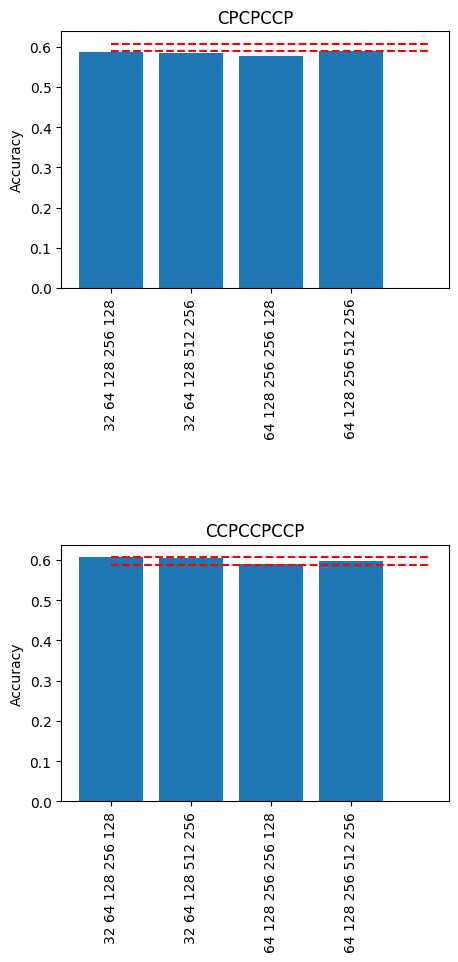

In [21]:
titles = ['CPCPCCP', 'CCPCCPCCP']
plots = [acc_model1, acc_model2]
best_model_acc = np.max(plots, axis=1)
labels = ['32 64 128 256 128', '32 64 128 512 256', '64 128 256 256 128', '64 128 256 512 256']

fig, axes = plt.subplots(2, 1, figsize=(5, 10))
fig.subplots_adjust(hspace=1)

for ax, plot, title in zip(axes.flatten(), plots, titles):
    ax.bar(labels, plot)
    ax.hlines(best_model_acc, 0, 4, 'r', '--')
    ax.set_xticklabels(labels, rotation = 90)
    ax.set_ylabel("Accuracy")
    ax.set_title(title)

plt.show()